# Variational autoencoders

So far, we've covered many examples of how to train models in a supervised fashion. However, there are many applications of neural networks outside the supervised regime. In this tutorial, we'll implement and train a variational autoencoder (VAE) to embed and generate images from the MNIST dataset.

You'll learn how to

- implement custom Flux.jl models
- write a custom training loop
- generate new images and visualize them

In [35]:
using FastAI, StaticArrays, Colors
using FastAI: FluxTraining, Image
import CairoMakie  # run if in an interactive environment like a notebook

## Setting up the data

First we load the MNIST dataset. Since we're not using it for supervised learning, we only need the input images, and don't load the labels. We get a data container where every observation is an image:

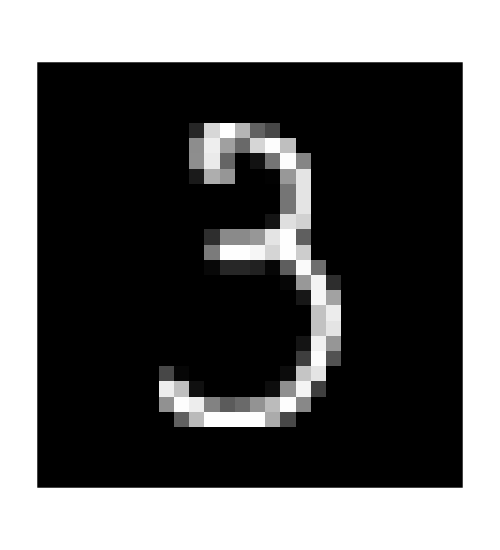

In [13]:
path = datasetpath("mnist_tiny")
data = Datasets.loadfolderdata(
    path,
    filterfn = isimagefile,
    loadfn = loadfile,
)
showblock(FastAI.Vision.Image{2}(), getobs(data, 1))

Next we need to define a learning task that will handle data encoding and decoding as well as visualization for us. So far, we've used [`SupervisedTask`](#) a lot which assumes there is an input that is fed to the model and a corresponding target output. Since we want to do unsupervised learning, we'll instead create a custom learning task using [`BlockTask`](#). It defines what kind of data we'll have at each step in the data pipeline for example `x` is a model input and `ŷ` a model output. See [`AbstractBlockTask`](#) for more info.

In [4]:
using FastAI: encodedblockfilled, decodedblockfilled

function EmbeddingTask(block, encodings)
    sample = block
    encodedsample = x = y = ŷ = encodedblockfilled(encodings, sample)
    blocks = (; sample, x, y, ŷ, encodedsample)
    BlockTask(blocks, encodings)
end


EmbeddingTask (generic function with 1 method)

With this helper defined, we can create a learning task for our task: `Image{2}()` is the kind of data we want to learn with and `ImagePreprocessing` makes sure to encode and decode these images so they can be used to train a model.

In [5]:
task = EmbeddingTask(
    Image{2}(),
    (ImagePreprocessing(means = SVector(0.0), stds = SVector(1.0), C = Gray{Float32}),),
)

BlockTask(blocks=(:sample, :x, :y, :ŷ, :encodedsample))

With the learning task set up, we can use `encode` to get samples ready to be input to a model, and all `show*` functions to visualize data at various points of the pipeline:

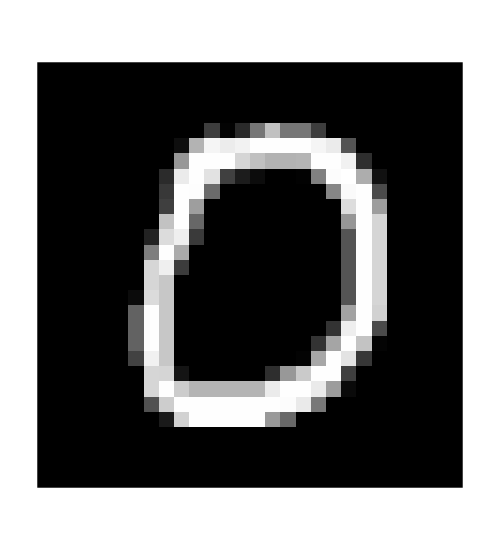

In [6]:
x = encodesample(task, Training(), getobs(data, 1))
showencodedsample(task, x)

For later training, the last thing we need to do with the data is to create a data iterator over batches of encoded samples. Since the dataset comfortably fits into memory, we preload it all at once by using `collect` on the `DataLoader`. This saves us having to reload each image again every epoch.

In [24]:
BATCHSIZE = nobs(data)
dataloader = DataLoader(taskdataset(shuffleobs(data), task, Training()), BATCHSIZE)
dataiter = collect(dataloader)

1-element Vector{Any}:
 [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; … ;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]

With that, we have a data iterator of batches that we can use in a training loop just by iterating over it:

In [25]:
for xs in dataiter
    print(size(xs))
    break
end

(28, 28, 1, 1428)

Next, we need to construct a model and define a loss function so it can be optimized.

## Modelling

The variational autoencoder consists of two parts: an encoder, and a decoder. The encoder takes in data and outputs parameters of a probability distribution. These are then used to sample latent vectors which are fed into the decoder to produce new samples. A loss function (ELBO) rewards the model if the outputs are similar to the inputs. The challenge is that the latent space is of much lower dimensionality than the data space, so the model needs to learn to compress the information contained in the data. If you're interested in more mathematical background on VAEs and the loss function, Lilian Weng has written a [great write-up on autoencoders](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#contractive-autoencoder). The architecture looks like this:

![Diagram of VAE architecture](./assets/vae.png)

We define the Variational Autoencoder model as a new type that wraps an encoder and decoder model and define the forward pass and loss function as regular Julia functions. 

In [26]:
struct VAE{E, D}
    encoder::E
    decoder::D
end

Flux.@functor VAE

function (vae::VAE)(xs)
    μ, logσ² = vae.encoder(xs)
    zs = sample_latent(μ, logσ²)
    x̄s = vae.decoder(zs)
    return x̄s, (; μ, logσ²)
end


using Random: randn!
using Statistics: mean

sample_latent(μ::AbstractArray{T}, logσ²::AbstractArray{T}) where {T} =
    μ .+ exp.(logσ² ./ 2) .* randn!(similar(logσ²))

function βELBO(x, x̄, μ, logσ²; β = 1)
    reconstruction_error = mean(sum(@.((x̄ - x)^2); dims = 1))
    # D(N(μ, Σ)||N(0, I)) = 1/2 * (μᵀμ + tr(Σ) - length(μ) - log(|Σ|))
    kl_divergence = mean(sum(@.((μ^2 + exp(logσ²) - 1 - logσ²) / 2); dims = 1))

    return reconstruction_error + β * kl_divergence
end

βELBO (generic function with 1 method)

Next we define the encoder and decoder models by composing basic Flux.jl layers. `Dlatent` is the size of the latent space and controls how much the model has to compress the information. Feel free to try out smaller or larger numbers and see how the quality of the generated images changes.

In [36]:
SIZE = (28, 28, 1)
Din = prod(SIZE)
Dhidden = 512
Dlatent = 4

encoder =
    Chain(
        flatten,
        Dense(Din, Dhidden, relu), # backbone
        Parallel(
            tuple,
            Dense(Dhidden, Dlatent), # μ
            Dense(Dhidden, Dlatent), # logσ²
        ),
    ) |> gpu

decoder = Chain(Dense(Dlatent, Dhidden, relu), Dense(Dhidden, Din, sigmoid), xs -> reshape(xs, SIZE..., :)) |> gpu

model = VAE(encoder, decoder);

## Custom training loop

When dealing with a unconvential learning scheme, we usually need to write a custom training loop. FastAI.jl is build on top of FluxTraining.jl which allows you to write custom training loops with very little boilerplate while retaining compatibility with its extensive callback system. In fact, the built-in training loops for supervised learning are defined in just the same way as we will.

In [37]:
struct VAETrainingPhase <: FluxTraining.AbstractTrainingPhase end

We just defined our own training phase. All that is required to take advantage of the FastAI.jl framework is to define the `FluxTraining.step!` function. We'll use a utility, `FluxTraining.runstep`, to reduce the boilerplate involved in handling callback events and state. `runstep`'s first argument is a function with inputs `(handle, state)`. `handle` can be used to dispatch events which callbacks can react to. `state` holds data generated on each call to `step!` like the batch, gradients, and loss. These are also accessible to callbacks, for example to calculate metrics. We also give `runstep` the initial step state which just contains our batch.

In [46]:

struct VAETrainingPhase <: FluxTraining.AbstractTrainingPhase end

function FluxTraining.step!(learner, phase::VAETrainingPhase, batch)
    FluxTraining.runstep(learner, phase, (xs = batch,)) do handle, state
        gs = gradient(learner.params) do
            μ, logσ² = learner.model.encoder(state.xs)
            state.zs = sample_latent(μ, logσ²)
            state.x̄s = learner.model.decoder(state.zs)

            handle(FluxTraining.LossBegin())
            state.loss = learner.lossfn(flatten(state.xs), flatten(state.x̄s), μ, logσ²)

            handle(FluxTraining.BackwardBegin())
            return state.loss
        end
        handle(FluxTraining.BackwardEnd())
        Flux.Optimise.update!(learner.optimizer, learner.params, gs)
    end
end


Since the step state is a little different from the supervised case (there are no targets `ys`), we also overwrite the default task for the `ToDevice` callback for our training phase:

In [48]:
function FluxTraining.on(
    ::FluxTraining.StepBegin,
    ::VAETrainingPhase,
    cb::ToDevice,
    learner,
)
    learner.step.xs = cb.movedatafn(learner.step.xs)
end

## Training

Now we can put the pieces together, creating a [`Learner`](#).

In [40]:
learner = Learner(model, (), ADAM(), βELBO, ToGPU())
FluxTraining.removecallback!(learner, ProgressPrinter);

To override the default supervised training loops, we pass our custom training phase and the data iterator we want to run it on to [`fitonecycle!`](#):

In [49]:
fitonecycle!(
    learner,
    30,
    0.01;
    phases = (VAETrainingPhase() => dataiter,),
)

┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │   1.0 │ 181.964 │
└──────────────────┴───────┴─────────┘
┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │   2.0 │ 178.809 │
└──────────────────┴───────┴─────────┘
┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │   3.0 │ 167.562 │
└──────────────────┴───────┴─────────┘
┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │   4.0 │ 155.867 │
└──────────────────┴───────┴─────────┘
┌──────────────────┬───────┬─────────┐
│            Phase │ Epoch │    Loss │
├──────────────────┼───────┼─────────┤
│ VAETrainingPhase │   5.0 │ 102.829 │
└──────────────────┴───────┴─────────┘
┌──────────────────┬─────

Finally, we can visualize how well inputs are reconstructed:

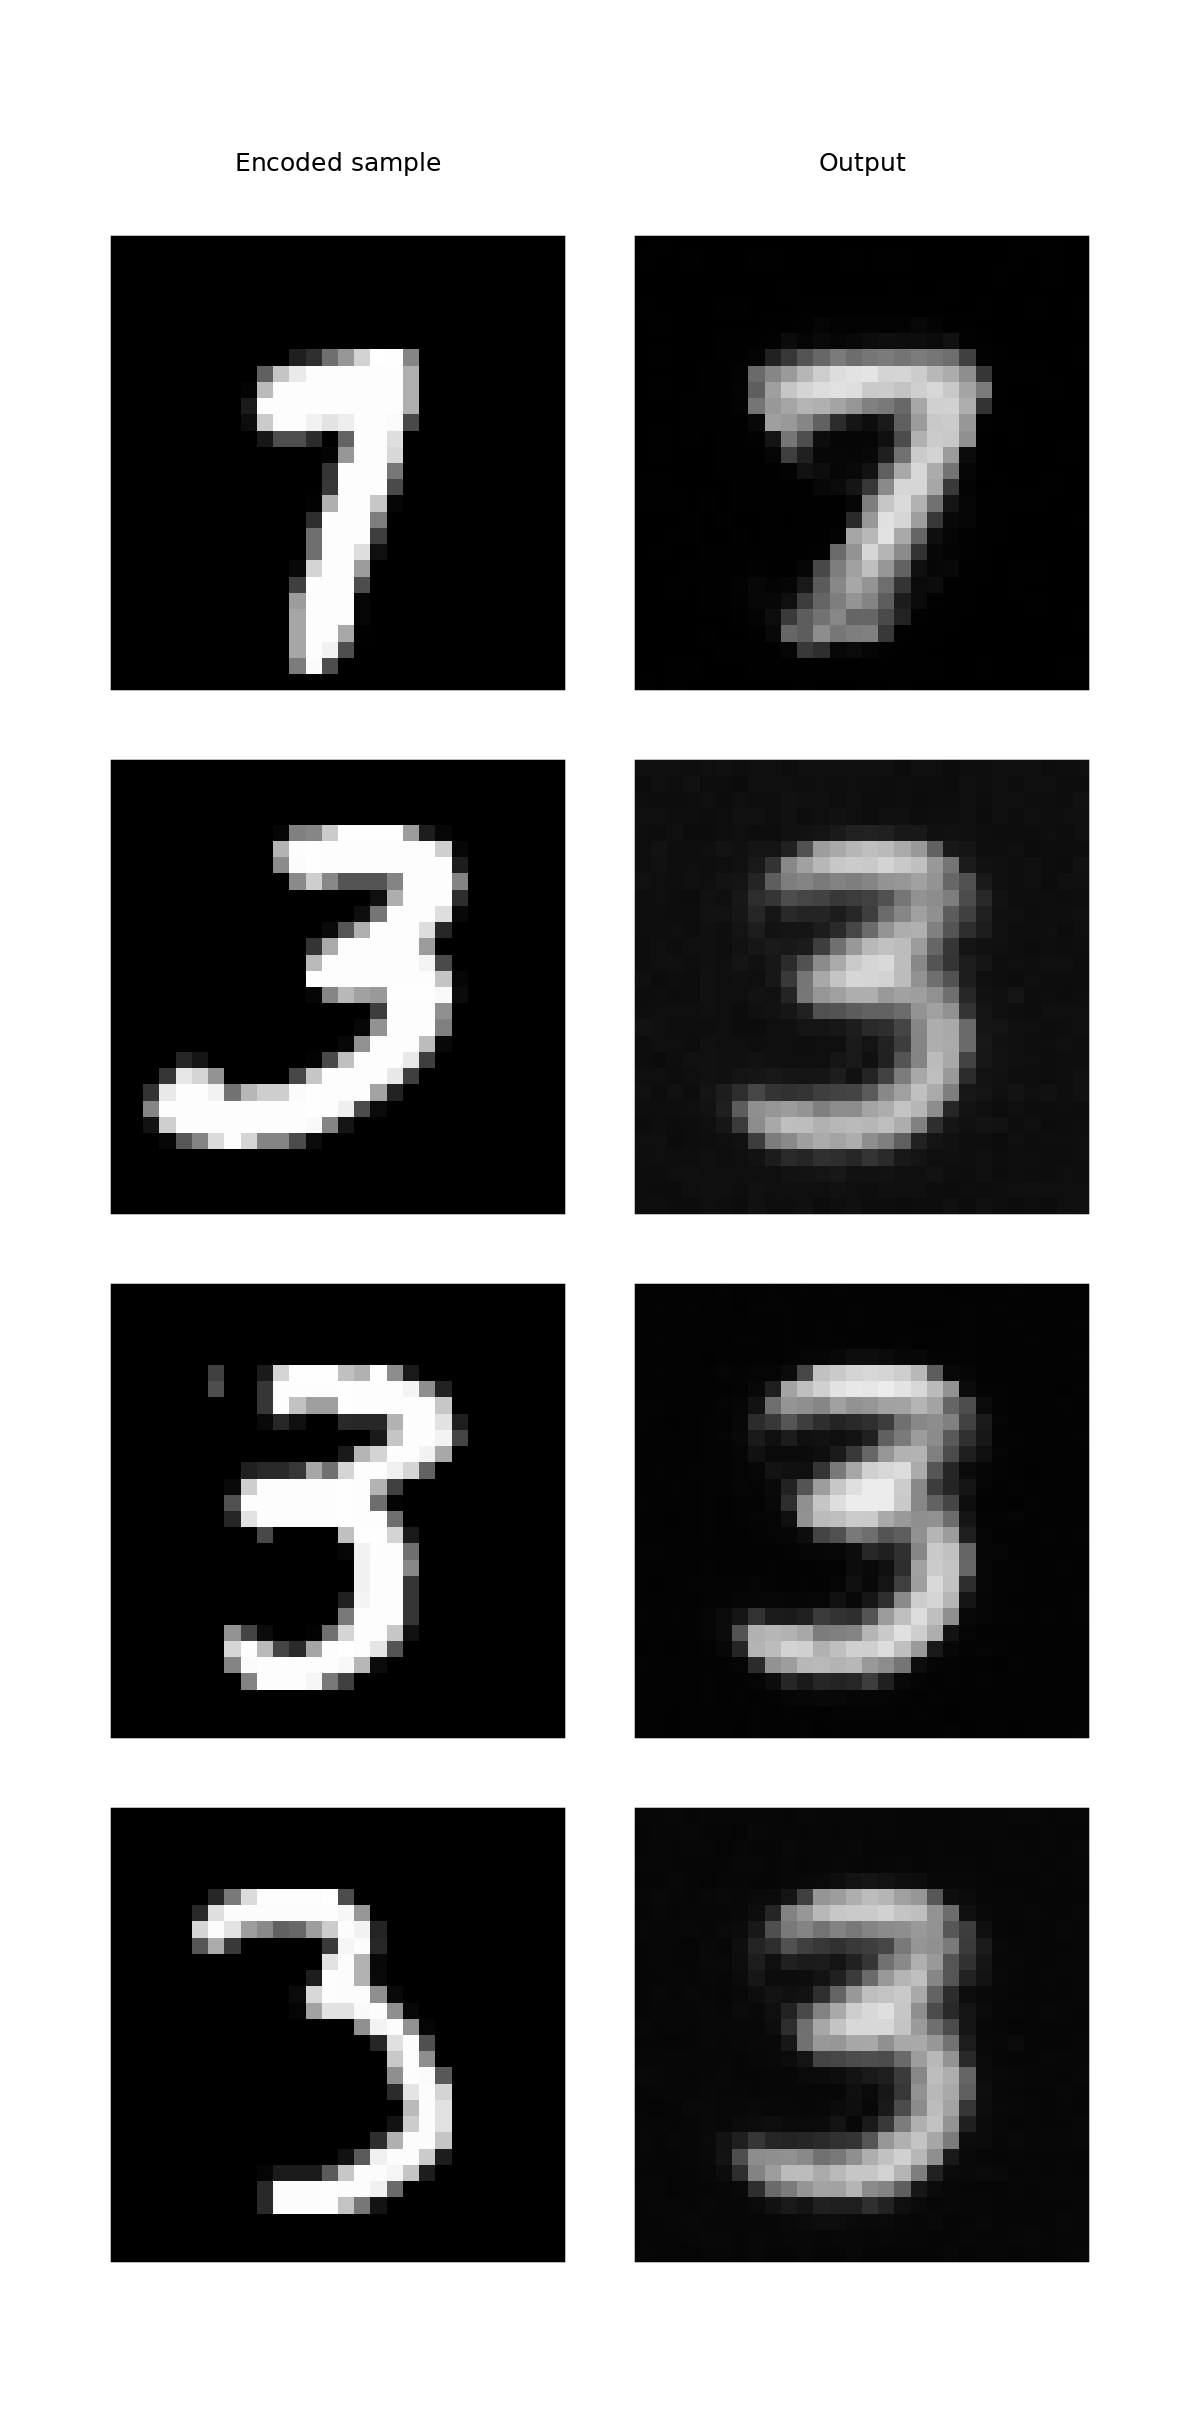

In [55]:
xs = makebatch(task, data, rand(1:nobs(data), 4)) |> gpu
ypreds, _ = model(xs)
showoutputbatch(task, cpu(xs), cpu(ypreds))

---

Next, why not play around a little bit:

- What happens if you increase or decrease the size of the latent space, `Dlatent`?
- How do the results change if you adjust the model size (`Dhidden`) or use a different model architecture like convolutional nets?